**1. Project Introduction**

# Customer Churn Prediction: A Machine Learning Approach

**Goal:** Predict whether a customer will churn based on demographic, account, and service usage features.

**Dataset:** [Telco Customer Churn Dataset](https://www.kaggle.com/datasets/
blastchar/telco-customer-churn)  
**Tools:** Python, scikit-learn, XGBoost, SHAP, SMOTE  

The notebook includes:
- Exploratory Data Analysis (EDA)
- Data Preprocessing
- Model Building (Logistic Regression & Decision Tree)
- Evaluation and Feature Importance




**2. Import Required Libraries**

In [61]:
# Importing Basic packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
!pip install shap scikit-learn xgboost imbalanced-learn


#Modeling & preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

#Interpretability
import shap
import warnings
warnings.filterwarnings("ignore")





**3. Upload and Load Dataset**

In [62]:
# Uploading and load the dataset
from google.colab import files
uploaded = files.upload()

# Read CSV into a pandas dataframe
df = pd.read_csv("Telco-Customer-Churn.csv")
df.head()



Saving Telco-Customer-Churn.csv to Telco-Customer-Churn (3).csv


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


**4. Data Cleaning**

In [63]:
# Converting TotalCharges to numeric and handling missing
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

#Droping rows with missing TotalCharges
df.dropna(inplace=True)
df.drop('customerID', axis=1, inplace=True)

# Converting churn column to binary
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})




**5. Churn Distribution**

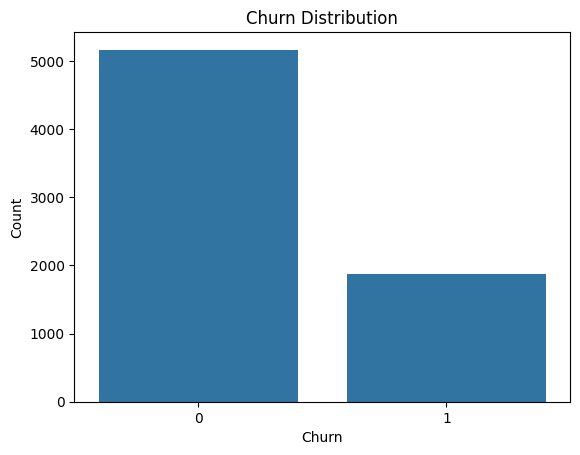

Churn Rate:
 Churn
0    73.421502
1    26.578498
Name: proportion, dtype: float64


In [64]:
# Churn class balance
sns.countplot(data=df, x='Churn')
plt.title("Churn Distribution")
plt.xlabel("Churn")
plt.ylabel("Count")
plt.show()

# Percentage
churn_rate = df['Churn'].value_counts(normalize=True) * 100
print("Churn Rate:\n", churn_rate)

## 📉 Churn Distribution

#The bar chart shows the distribution of the target variable `Churn`:

#- `0` = Customers who stayed
#- `1` = Customers who churned (left)

# Insights:
#- Around 73.4% of customers did not churn.
#- Only 26.6% of customers did churn.

#This indicates a class imbalance, which is common in churn prediction problems. Most customers remain loyal, while only a minority leave.

### Implication:
#- Machine learning models trained on imbalanced data may become biased toward predicting the majority class (non-churn).
#- To address this, we later apply SMOTE (Synthetic Minority Over-sampling Technique)** to balance the training data and improve recall on churners.

**6. Numerical Feature Distributions**

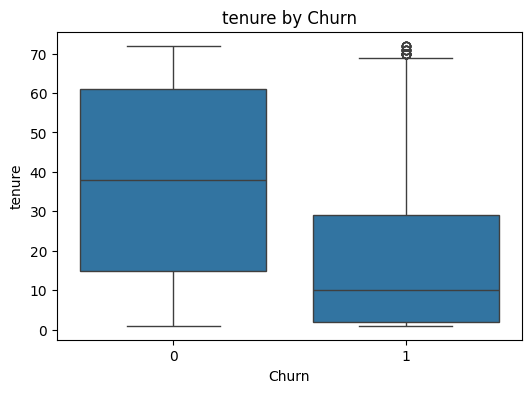

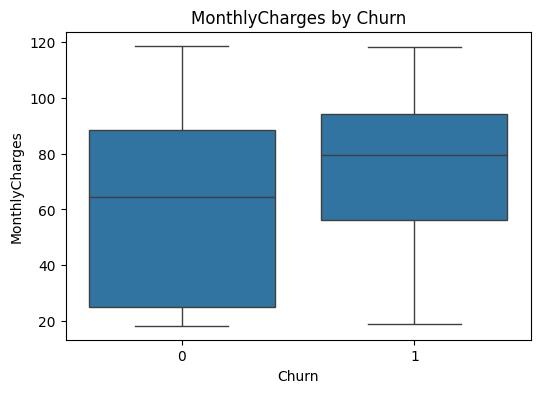

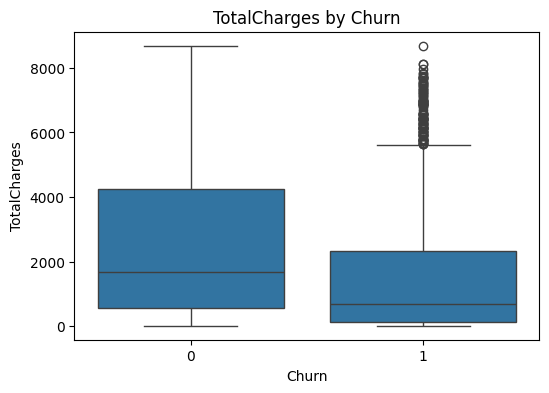

In [65]:
# Boxplots for numeric features vs churn
numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

for col in numeric_features:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='Churn', y=col, data=df)
    plt.title(f"{col} by Churn")
    plt.show()


## Boxplot Analysis
#The three boxplots compare the distributions of key numeric variables — `tenure`, `MonthlyCharges`, and `TotalCharges` — across churned (`1`) and retained (`0`) customers.

#Observations:
#1. Tenure by Churn:
 #  - Customers who churn tend to have much lower tenure.
 #  - Most churned customers have been with the company for less than 20 months.
 # This suggests newer customers are more likely to leave.

#2. Monthly Charges by Churn:
 #  - Churned customers typically pay higher monthly charges than those who stay.
 # This indicates a possible price sensitivity or dissatisfaction with perceived value.

#3. Total Charges by Churn:
 #  - Non-churned customers have a much wider spread and higher total charges, as expected — they've stayed longer.
 #  - Churned customers accumulate fewer total charges due to shorter tenure.

#Implications:

#- These patterns help identify early churn risks (e.g., customers with high monthly charges but low tenure).
#- We can use features like `tenure` and `MonthlyCharges` as strong predictors in our model.





**7. Correlation Matrix**

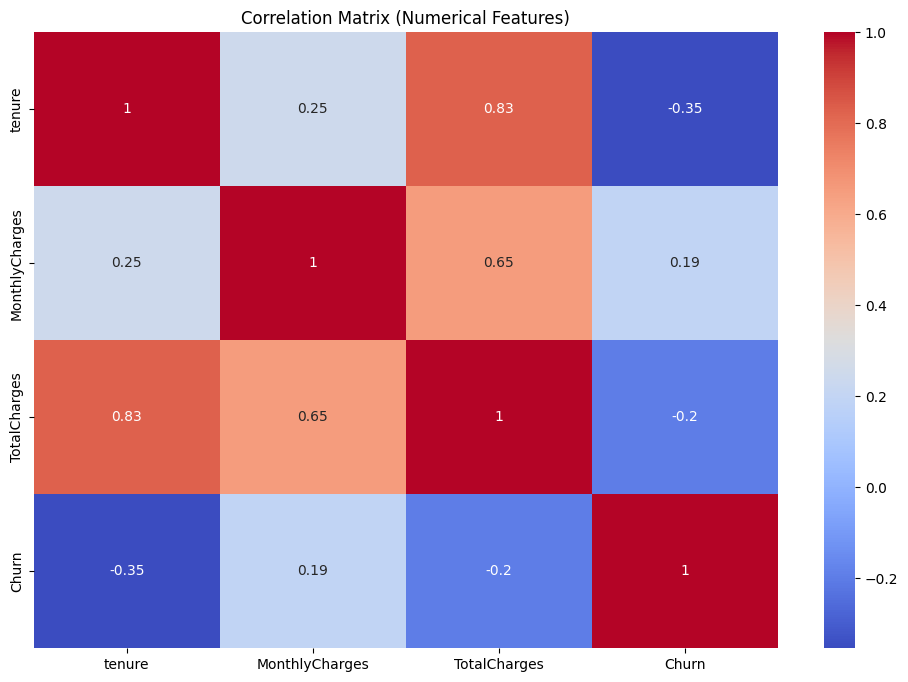

In [66]:
# Add churn back as numeric (if dropped)
df_corr = df.copy()
df_corr['Churn'] = df_corr['Churn'].astype(int)

# Compute correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(df_corr[numeric_features + ['Churn']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix (Numerical Features)")
plt.show()

## Correlation Matrix

#The heatmap visualizes the correlation coefficientsbetween key numeric variables in the dataset, including the target `Churn`.

#Key Insights:

#1. Tenure vs. Churn:
 #  - Correlation: -0.35
 #  - Indicates a moderate negative correlation — as tenure increases, the likelihood of churn decreases.
 #  Interpretation: Long-term customers are more likely to stay.

#2. MonthlyCharges vs. Churn:
 #  - Correlation: 0.19
 #  Weak positive correlation — customers with higher monthly charges may be slightly more likely to churn.

#3. TotalCharges vs. Churn:
 #  - Correlation: -0.20
 #  - Slight negative relationship — customers who’ve spent more over time are less likely to churn (likely due to longer tenure).

#4. Tenure vs. TotalCharges:
 #  - Correlation: +0.83
 #  Strong positive correlation — customers who’ve stayed longer have accumulated higher charges.

# Implications
 #- These correlations help us identify which numerical variables are meaningful predictors for churn.
 #- Features like tenure and monthly charges are especially important and will be weighted accordingly in model training.




**8. Categorical Feature Analysis**

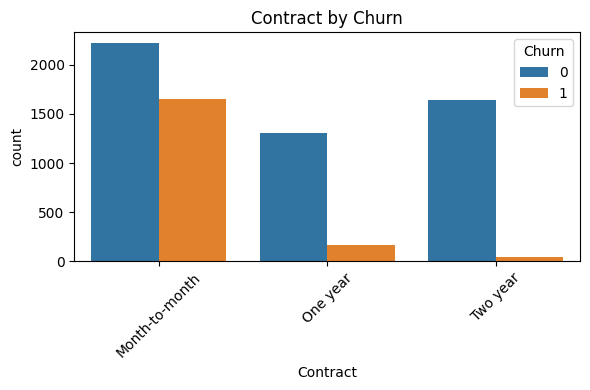

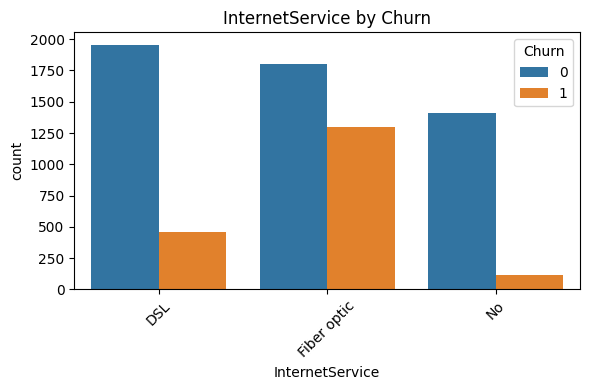

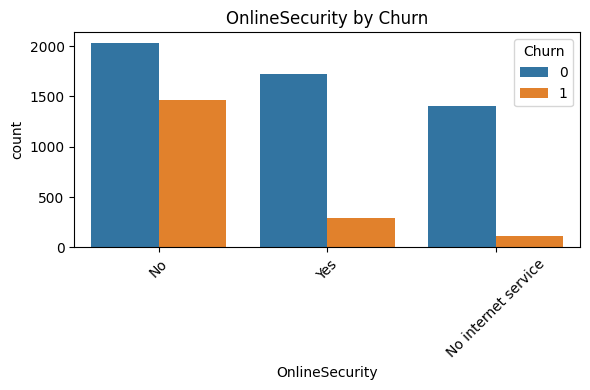

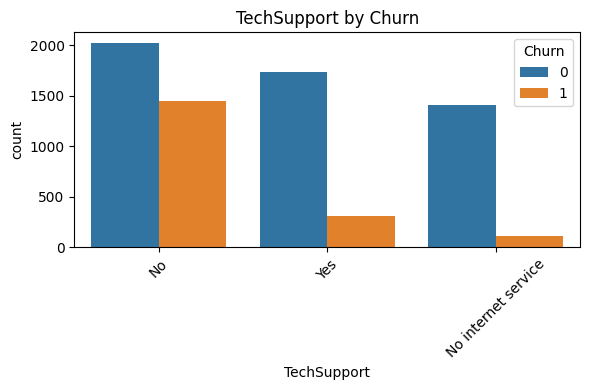

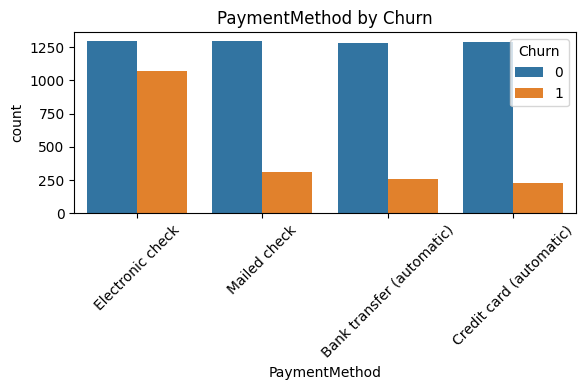

In [67]:
# Compare categorical variables vs churn
categorical = ['Contract', 'InternetService', 'OnlineSecurity', 'TechSupport', 'PaymentMethod']

for col in categorical:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=df, x=col, hue='Churn')
    plt.title(f"{col} by Churn")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

#Churn by Categorical Features

#1. Contract Type vs. Churn:
 # - Customers with Month-to-month contracts have the highest churn rate.
 #- Very few customers churn when on One year or Two year contracts.

#2. Internet Service Type vs. Churn:
 #- Customers using Fiber optic internet have a notably higher churn compared to DSL or those with no service.


# 3. Online Security vs. Churn:
 #- Customers without online security churn at significantly higher rates.
 #- Those with online security tend to stay longer.

# 4. Tech Support:
 #- Similar trend as OnlineSecurity: customers without TechSupport churn more.

# 5. Payment Method:
 #- Customers using Electronic check show the highest churn rate.
 #- Automated methods like Credit card and Bank transfer have lower churn.






**9. Feature Engineering & Encoding**

In [68]:

# Spliting numerical and categorical columns
cat_cols = df.select_dtypes(include='object').columns
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

# One-hot encoding
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Scale numeric
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

**10. Train-Test Split & SMOTE Balancing**

In [69]:
X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

# Balancing the training set with SMOTE technique
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)


**11. Training Models**



*   Logistic Regression Modeling - Logistic Regression is interpretable and shows how each feature affects the odds of churn. It’s useful for quick business decisions and benchmarking.
*   XGBoost Classifier - XGBoost is a high-performance, ensemble tree-based algorithm known for excellent results in classification problems.
*   Random Forest - Random Forest is used to build multiple decision trees and combines their outputs to improve performance and reduce overfitting.










In [70]:
# Training 3 different models and comparing their performance (Logistic Regression,Random Forest, XGBoost )
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

for name, model in models.items():
    model.fit(X_train_bal, y_train_bal)
    y_pred = model.predict(X_test)
    print(f"\n📘 {name}")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))



📘 Logistic Regression
              precision    recall  f1-score   support

           0       0.88      0.76      0.82      1549
           1       0.53      0.72      0.61       561

    accuracy                           0.75      2110
   macro avg       0.71      0.74      0.71      2110
weighted avg       0.79      0.75      0.76      2110

Confusion Matrix:
[[1183  366]
 [ 155  406]]

📘 Random Forest
              precision    recall  f1-score   support

           0       0.85      0.81      0.83      1549
           1       0.55      0.62      0.58       561

    accuracy                           0.76      2110
   macro avg       0.70      0.72      0.71      2110
weighted avg       0.77      0.76      0.77      2110

Confusion Matrix:
[[1260  289]
 [ 214  347]]

📘 XGBoost
              precision    recall  f1-score   support

           0       0.86      0.80      0.83      1549
           1       0.54      0.63      0.58       561

    accuracy                           0.


📘 Logistic Regression
              precision    recall  f1-score   support

           0       0.88      0.76      0.82      1549
           1       0.53      0.72      0.61       561

    accuracy                           0.75      2110
   macro avg       0.71      0.74      0.71      2110
weighted avg       0.79      0.75      0.76      2110



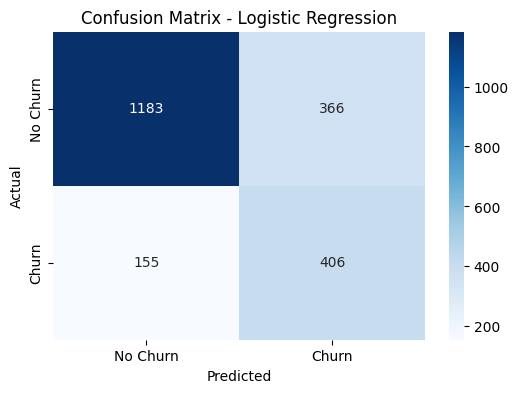


📘 Random Forest
              precision    recall  f1-score   support

           0       0.85      0.81      0.83      1549
           1       0.55      0.62      0.58       561

    accuracy                           0.76      2110
   macro avg       0.70      0.72      0.71      2110
weighted avg       0.77      0.76      0.77      2110



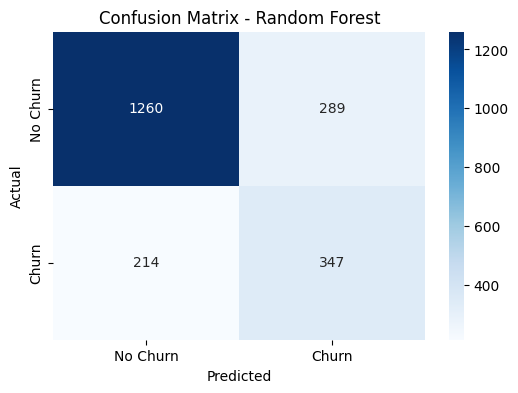


📘 XGBoost
              precision    recall  f1-score   support

           0       0.86      0.80      0.83      1549
           1       0.54      0.63      0.58       561

    accuracy                           0.76      2110
   macro avg       0.70      0.72      0.70      2110
weighted avg       0.77      0.76      0.76      2110



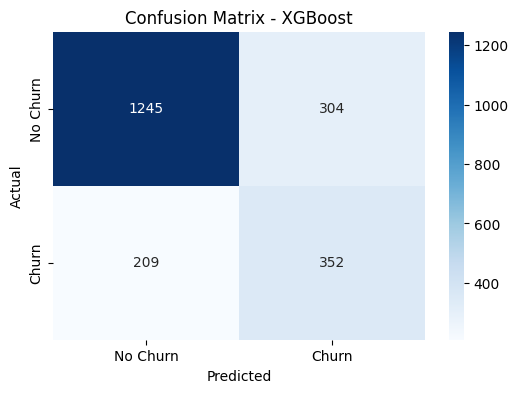

In [71]:

for name, model in models.items():
    model.fit(X_train_bal, y_train_bal)
    y_pred = model.predict(X_test)
    print(f"\n📘 {name}")
    print(classification_report(y_test, y_pred))

    # Generate and plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {name}')
    plt.show()

## Model Comparison: Logistic Regression vs. Random Forest vs. XGBoost

The charts above show performance metrics and confusion matrices for three classification models used to predict customer churn.

Each matrix shows:
- **True Negatives (TN)**: Top-left (correctly predicted "No Churn")
- **False Positives (FP)**: Top-right (incorrectly predicted churn when it was not)
- **False Negatives (FN)**: Bottom-left (missed actual churn)
- **True Positives (TP)**: Bottom-right (correctly predicted churn)

---

### Logistic Regression
- **Accuracy**: 0.75  
- **Recall (Churn class)**: 0.72  
- **F1-score (Churn class)**: 0.61  
- **Observation**:
  - Performs well in identifying churned customers (high recall).
  - Misclassifies many non-churners (366 FPs).
> Good for interpretability and baseline benchmarking.

---

### Random Forest
- **Accuracy**: 0.76  
- **Recall (Churn class)**: 0.62  
- **F1-score (Churn class)**: 0.58  
- **Observation**:
  - Strong at identifying non-churners (1260 TN).
  - Balanced but slightly worse at finding churn than Logistic Regression.
> Better overall accuracy but sacrifices recall slightly.

---

### XGBoost
- **Accuracy**: 0.76  
- **Recall (Churn class)**: 0.63  
- **F1-score (Churn class)**: 0.58  
- **Observation**:
  - Very close to Random Forest in all metrics.
  - Slight improvement in correctly detecting churn (352 TP vs. 347 in RF).
> Slight edge over Random Forest for churn class with similar overall performance.

---

### Summary Table

| Model              | Accuracy | Precision (Churn) | Recall (Churn) | F1-Score (Churn) |
|-------------------|----------|-------------------|----------------|------------------|
| Logistic Regression | 0.75     | 0.53              | **0.72**       | **0.61**         |
| Random Forest       | 0.76     | 0.55              | 0.62           | 0.58             |
| XGBoost             | 0.76     | 0.54              | 0.63           | 0.58             |

---

### Takeaways:
- **Logistic Regression** has the best **recall**, making it useful if we want to catch as many churners as possible.
- **XGBoost and Random Forest** offer better overall balance and slightly better precision.
- The best model depends on the business goal:
  - If minimizing false negatives (missing churners): **Logistic Regression**
  - If optimizing overall accuracy and reducing false positives: **XGBoost**




**13. ROC Curve and AUC**

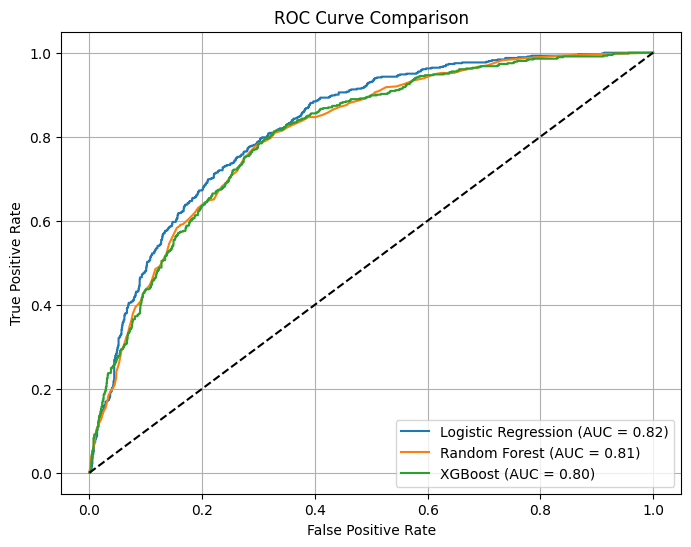

In [72]:
# Plotting ROC curves for all models

plt.figure(figsize=(8, 6))
for name, model in models.items():
    y_probs = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    auc = roc_auc_score(y_test, y_probs)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid()
plt.show()


##ROC Curve Comparison: Logistic Regression vs. Random Forest vs. XGBoost

The ROC (Receiver Operating Characteristic) curve plots the **True Positive Rate (Recall)** against the **False Positive Rate** across different classification thresholds.

### What It Tells Us:
- The closer a curve is to the **top-left corner**, the better the model distinguishes between churn and no churn.
- The **Area Under the Curve (AUC)** quantifies the model’s ability to separate the classes.
  - AUC = 1.0 → Perfect classifier
  - AUC = 0.5 → No better than random guessing

---

### Model AUC Scores:
- **Logistic Regression**: **AUC = 0.82**
- **Random Forest**: **AUC = 0.81**
- **XGBoost**: **AUC = 0.80**

---

### Interpretation:
- All three models perform well, with AUC values > 0.80.
- **Logistic Regression** has the highest AUC, indicating slightly better discrimination of churn vs. non-churn cases.
- While XGBoost and Random Forest have slightly lower AUC, their performance is comparable and may offer benefits in other areas (e.g., precision or feature handling).

---

### Why ROC-AUC Matters:
- It’s threshold-independent — evaluates overall model quality.
- Helps compare models beyond simple accuracy or recall.
- Important when balancing **true churn detection** and **false alarm rates**.



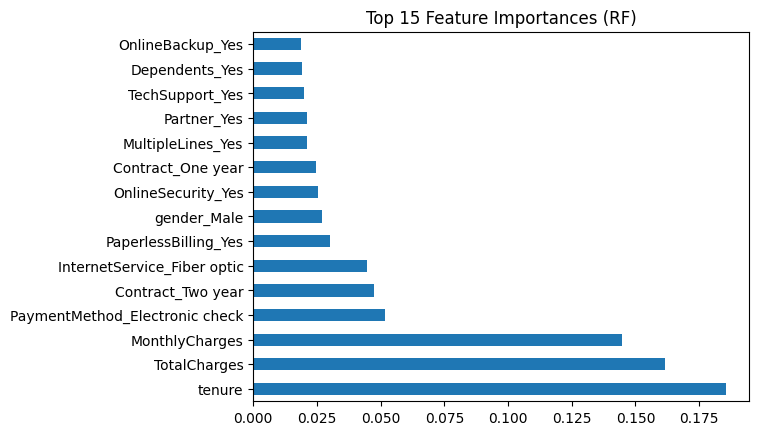

In [73]:
#Plotting top 15 feature importances from Random Forest
feat_imp = pd.Series(models['Random Forest'].feature_importances_, index=X.columns)
feat_imp.nlargest(15).plot(kind='barh')
plt.title("Top 15 Feature Importances (RF)")
plt.show()


## Top 15 Feature Importances (Random Forest)

The bar chart above shows the top 15 most important features identified by the Random Forest model. Feature importance reflects the **contribution of each variable** in making accurate churn predictions.

---

### Most Influential Features:

1. **Tenure**:  
   - The most important feature by far.
   - Customers with short tenure are more likely to churn.
   - Reinforces earlier findings from boxplots and correlation analysis.

2. **TotalCharges** and **MonthlyCharges**:  
   - Key financial indicators.
   - High monthly charges (especially when tenure is low) often signal churn risk.

3. **PaymentMethod_Electronic check**:  
   - Strongly associated with higher churn in prior analysis.
   - Suggests certain payment types correlate with disengagement or dissatisfaction.

4. **Contract_Two year** and **Contract_One year**:  
   - Lower churn when long-term contracts are in place.
   - Important categorical predictor for retention modeling.

5. **InternetService_Fiber optic** and **OnlineSecurity_Yes**:  
   - Capture service quality and add-on adoption.
   - Fiber users churn more; customers with online security churn less.

---

### Insights:
- These insights validate earlier **EDA findings** with statistical backing.



**14. SHAP Explainability**

SHAP (SHapley Additive exPlanations) is used to explain individual predictions and global feature importance

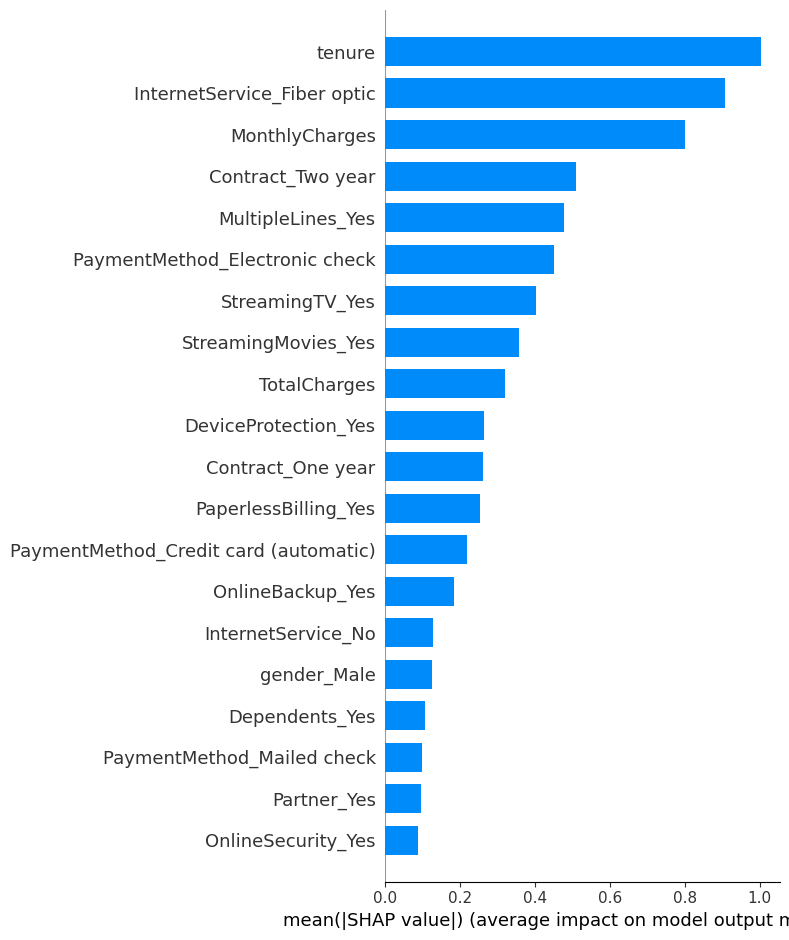

In [74]:
# SHAP summary plot for XGBoost
explainer = shap.Explainer(models['XGBoost'])
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")


## SHAP Summary Plot: Feature Impact on Churn Prediction

This bar plot shows the **average SHAP (SHapley Additive exPlanations) values** for the most important features in the churn prediction model.

- SHAP values represent each feature’s **average contribution to the model output**.
- A higher value indicates a **greater impact** (positive or negative) on the prediction outcome.

---

### Top Influential Features:

1. **tenure**  
   - Most impactful feature overall.
   - Lower tenure generally increases churn risk (shorter-term customers are less loyal).

2. **InternetService_Fiber optic**  
   - Fiber users have higher churn risk (possibly due to pricing or quality expectations).

3. **MonthlyCharges**  
   - Higher monthly charges contribute to churn.
   - Confirms prior EDA and correlation analysis.

4. **Contract_Two year**  
   - Strong negative impact on churn — i.e., two-year contracts reduce churn risk.

5. **PaymentMethod_Electronic check**  
   - Associated with increased churn, consistent with earlier visualizations.

---

###Interpretation Benefits:
- SHAP is **model-agnostic and interpretable**, helping you **explain predictions to non-technical stakeholders**.
- Unlike raw feature importance, SHAP quantifies both **magnitude and direction** of each feature’s influence.



In [75]:
# Checking model recall across subgroups here -  SeniorCitizen
X_test_copy = X_test.copy()
X_test_copy['SeniorCitizen'] = df.loc[X_test_copy.index, 'SeniorCitizen']
y_pred_rf = models['Random Forest'].predict(X_test)

from sklearn.metrics import recall_score
for group in [0, 1]:
    idx = X_test_copy['SeniorCitizen'] == group
    group_recall = recall_score(y_test[idx], y_pred_rf[idx])
    print(f"Recall for SeniorCitizen = {group}: {group_recall:.2f}")

#This helps determine whether the model performs equally well across age-based subgroups hence showing less bias in the subgroup and the model overall

Recall for SeniorCitizen = 0: 0.59
Recall for SeniorCitizen = 1: 0.70
